In [1]:
import os
import cv2
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, random_split, Subset


from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import math
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import seaborn as sns

In [ ]:
# --- Configuration ---
DATA_DIR = './data'
N_CLUSTERS = 1000 # BoVW size
MAX_KP = 500 # max number of keypoints per image
PATCH_SIZE = 16 # patch size for SIFT
INTEREST_METHOD = 'Harris' # 'DoG', 'Harris'
EPOCHS = 15 # epoches for softmax
LR = 1e-3 #lr for softmax

In [3]:
# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [ ]:
# --- 1. Interest Point Detection ---
def detect_interest_points(gray, method='DoG', threshold=5):
    if method == 'DoG':
        # Define multiple sigma values for Gaussian blur
        num_octaves=3 # the level of the image pyramid
        scales_per_octave=3 # the number of scales per octave
        sigma0=1.6 # otiginal sigma value
        
        keypoints = []
        k = 2 ** (1 / scales_per_octave)  # the scale factor for each scale
        
        # form the 0th octave to num_octaves-1 octaves
        for octave in range(num_octaves):
            # create the base image for the current octave
            if octave == 0:
                base = gray.copy()
            else:
                # downsample the previous base image
                base = cv2.pyrDown(prev_base)
            
            # save the current base for the next octave
            prev_base = base
            # calculate the size of the base image
            h, w = base.shape
            
            # create the Gaussian pyramid
            # scales_per_octave + 3 scales，to produce scales_per_octave+2 DoG layers
            sigmas = [sigma0 * (k ** (i + octave*scales_per_octave)) for i in range(scales_per_octave + 3)]
            gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
            
            # calculate DoG
            dogs = []
            for i in range(len(gaussians)-1):
                diff = gaussians[i+1].astype(np.float32) - gaussians[i].astype(np.float32)
                dogs.append(diff)
            
            # find the scale-space extrema
            for i in range(1, len(dogs)-1):
                # the three layers to compare
                prev_d, curr_d, next_d = dogs[i-1], dogs[i], dogs[i+1]

                # dilation is used to find the maximum
                max_spat = cv2.dilate(curr_d, np.ones((3,3),np.uint8))
                # erosion is used to find the minimum
                min_spat = cv2.erode( curr_d, np.ones((3,3),np.uint8))
                
                mask_max = (curr_d == max_spat) & (curr_d > prev_d) & (curr_d > next_d) & (np.abs(curr_d) > threshold)
                mask_min = (curr_d == min_spat) & (curr_d < prev_d) & (curr_d < next_d) & (np.abs(curr_d) > threshold)
                
                # Find all coordinates of the points that satisfy the conditions
                coords = np.vstack((np.argwhere(mask_max), np.argwhere(mask_min)))

                # map the coord back to the original image
                for y, x in coords:
                    # make downsampling back
                    scale = (2 ** octave)
                    kp = cv2.KeyPoint(float(x*scale), float(y*scale), size=PATCH_SIZE * scale)
                    keypoints.append(kp)
                    
        keypoints = sorted(keypoints, key=lambda kp: kp.response if hasattr(kp, 'response') else 1.0, reverse=True)
        return keypoints[:MAX_KP]
    elif method == 'Harris':
        # calculate Harris corner response
        H = cv2.cornerHarris(
            gray.astype(np.float32),
            blockSize=2,
            ksize=3,
            k=0.04
        )

        # normalize the response to [0, 1]
        Hn = cv2.normalize(H, None, 0, 1, cv2.NORM_MINMAX)

        # get local maximum
        dil = cv2.dilate(Hn, np.ones((3,3), np.uint8))
        nms_mask = (Hn == dil)

        # thresholding
        mask = nms_mask & (Hn > 0.01*threshold)

        # get kps
        ys, xs = np.where(mask)
        keypoints = []
        for y, x in zip(ys, xs):
            kp = cv2.KeyPoint(
                x=float(x), y=float(y),
                size=float(PATCH_SIZE),
                response=float(Hn[y, x])
            )
            keypoints.append(kp)

        # order keypoints by response
        keypoints.sort(key=lambda kp: kp.response, reverse=True)
        return keypoints[:MAX_KP]
    

    elif method == 'LoG':
        log = cv2.Laplacian(gray, cv2.CV_64F)
        coords = np.argwhere(np.abs(log) > threshold)
    else:
        sift = cv2.SIFT_create()
        kps = open_kps = sift.detect(gray, None)
        # raise ValueError('Unsupported method')
    # Create keypoints and limit count
    return kps[:MAX_KP]

In [ ]:
# --- Interest Point Detector: Harris-Laplace ---
# if you want to use DoG and Harris, please comment the following function
def detect_interest_points(gray,
                            method=INTEREST_METHOD,
                            num_octaves=3,
                            scales_per_octave=3,
                            sigma0=1.6,
                            harris_block=2,
                            harris_ksize=3,
                            harris_k=0.04,
                            harris_thresh=0.01):
    keypoints = []
    k = 2 ** (1 / scales_per_octave)
    # 1) Build Gaussian pyramid bases
    gp = []
    for octave in range(num_octaves):
        base = gray if octave == 0 else cv2.pyrDown(gp[-1])
        gp.append(base)

    # 2) Build Gaussian blurred images per octave
    gauss_pyr = []  # list of lists: gauss_pyr[octave][scale]
    for o, base in enumerate(gp):
        sigmas = [sigma0 * (k ** (i + o*scales_per_octave))
                  for i in range(scales_per_octave + 3)]
        gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
        gauss_pyr.append(gaussians)

    # 3) Harris detection per scale (spatial localization)
    harris_pyr = []  # harris_pyr[octave][scale] = boolean mask
    for o, gaussians in enumerate(gauss_pyr):
        masks = []
        for img in gaussians:
            H = cv2.cornerHarris(np.float32(img), blockSize=harris_block,
                                 ksize=harris_ksize, k=harris_k)
            Hn = cv2.normalize(H, None, 0, 1, cv2.NORM_MINMAX)
            # spatial Non-Max Suppression
            max_spat = cv2.dilate(Hn, np.ones((3,3), np.uint8))
            mask = (Hn == max_spat) & (Hn > harris_thresh)
            masks.append(mask)
        harris_pyr.append(masks)

    # 4) Compute Laplacian-of-Gaussian responses per scale for scale selection
    log_pyr = []  # log_pyr[octave][scale]
    for gaussians in gauss_pyr:
        logs = [cv2.Laplacian(img, cv2.CV_32F, ksize=3) for img in gaussians]
        log_pyr.append(logs)

    # 5) Combine: for each Harris candidate, pick scale with max |LoG|
    seen = set()
    for o, masks in enumerate(harris_pyr):
        for s_idx, mask in enumerate(masks):
            ys, xs = np.where(mask)
            for y, x in zip(ys, xs):
                # scale selection
                responses = [abs(log_pyr[o][i][y, x]) for i in range(len(log_pyr[o]))]
                best_i = int(np.argmax(responses))
                # map to original image coordinates
                scale_factor = 2 ** o
                X = int(x * scale_factor)
                Y = int(y * scale_factor)
                if (X, Y) in seen:
                    continue
                seen.add((X, Y))
                # size proportional to sigma
                best_sigma = sigma0 * (k ** (best_i + o*scales_per_octave))
                size = PATCH_SIZE * best_sigma
                kp = cv2.KeyPoint(float(X), float(Y), size)
                kp.response = responses[best_i]
                keypoints.append(kp)

    # 6) sort by response and limit
    keypoints.sort(key=lambda kp: kp.response, reverse=True)
    return keypoints[:MAX_KP]
# 22 19 19 12

In [ ]:
# --- 2. Compute Custom SIFT-like Descriptor ---
def compute_custom_sift_descriptor(gray, keypoints, patch_size=PATCH_SIZE):
    # Compute gradients once
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(grad_x, grad_y)
    ori = cv2.phase(grad_x, grad_y, angleInDegrees=True)

    descriptors = []
    half = patch_size // 2
    h, w = gray.shape

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # boundary check
        if x-half < 0 or y-half < 0 or x+half >= w or y+half >= h:
            continue
        # extract full patch
        mag_full = mag[y-half:y+half, x-half:x+half]
        ori_full = ori[y-half:y+half, x-half:x+half]
        # 1) Orientation assignment: build 8-bin histogram over full patch
        hist8, bin_edges = np.histogram(ori_full.ravel(), bins=8, range=(0,360), weights=mag_full.ravel())
        # main orientation is center of max bin
        max_idx = np.argmax(hist8)
        main_ori = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2.0
        # normalize full patch orientations relative to main orientation
        ori_full = (ori_full - main_ori + 360) % 360
        # slice into subregions and build descriptor
        desc = []
        for i in range(4):
            for j in range(4):
                sub_mag = mag_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                sub_ori = ori_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                # 2) histogram on aligned orientations
                hsub, _ = np.histogram(sub_ori, bins=8, range=(0,360), weights=sub_mag)
                desc.extend(hsub)
        desc = np.array(desc, dtype=np.float32)
        desc /= (np.linalg.norm(desc) + 1e-7)
        descriptors.append(desc)

    return np.array(descriptors) if descriptors else None

In [ ]:
# --- 3. Load CIFAR-10 ---
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([
    # lager the image to 128×128
    transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC),

    # transforms.RandomCrop(120, padding=4),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.2,
    #                        contrast=0.2,
    #                        saturation=0.2,
    #                        hue=0.1),

    # to Tensor, then normalize to [0,1]
    transforms.ToTensor(),

    # normalization, use the mean and std pre-computed on the training set
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
    #                      std =[0.2470, 0.2435, 0.2616]),
])

trainset = CIFAR10(DATA_DIR, train=True, download=True, transform=transform)
testset  = CIFAR10(DATA_DIR, train=False, download=True, transform=transform)
print(f"Trainset size: {len(trainset)}")
print(f"Testset size: {len(testset)}")


# Downsample trainset to 30% of original size
np.random.seed(42)  # fix random seed
total_size      = len(trainset)
subsample_size  = int(total_size * 0.3)
all_indices     = np.arange(total_size)
subsample_index = np.random.choice(all_indices, subsample_size, replace=False)

subset_train_val = Subset(trainset, subsample_index)

# in the 30%, 80% for training, 20% for validation
train_size = int(len(subset_train_val) * 0.8)
val_size   = len(subset_train_val) - train_size

generator = torch.Generator().manual_seed(42)
trainset, testset = random_split(
    subset_train_val,
    [train_size, val_size],
    generator=generator
)
print(f"Trainset size: {len(trainset)}")
print(f"Testset size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Trainset size: 50000
Testset size: 10000
Trainset size: 12000
Testset size: 3000


### View of data augmentation

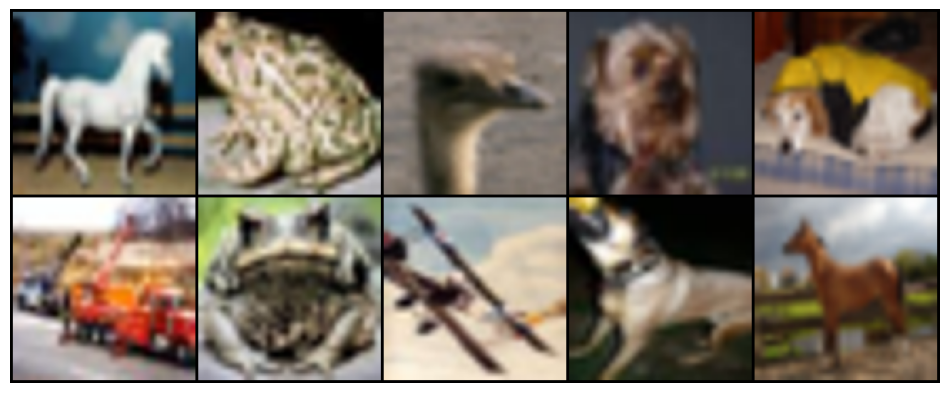

In [ ]:

# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
# std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
# inv_norm = transforms.Normalize((-mean/std).squeeze(), (1/std).squeeze())

indices = random.sample(range(len(trainset)), 10)
imgs = []
for idx in indices:
    img, _ = trainset[idx]
    # img = inv_norm(img)
    # img = torch.clamp(img, 0, 1)
    imgs.append(img)

grid = make_grid(imgs, nrow=5, padding=2)
plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Formal Training

In [13]:
# --- 4. Extract descriptors from training set ---
# def extract_descriptors(trainset, method=INTEREST_METHOD):
#     """
#     Extracts SIFT-like descriptors from the training set.
#     Returns a list of descriptors and their corresponding labels.
#     """
#     all_desc = []
#     img_desc_idx = []
#     train_labels = []
#     print('Extracting training descriptors...')
#     for img, label in tqdm(trainset, desc='Train images'):
#         img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
#         gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
#         kps = detect_interest_points(gray, method=INTEREST_METHOD)
#         des = compute_custom_sift_descriptor(gray, kps)
#         if des is not None:
#             all_desc.extend(des)
#         img_desc_idx.append(len(all_desc))
#         train_labels.append(label)
#     all_desc = np.vstack(all_desc)
#     return all_desc, img_desc_idx, train_labels
all_desc = []
img_desc_idx = []
train_labels = []
print('Extracting training descriptors...')
for img, label in tqdm(trainset, desc='Train images'):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is not None:
        all_desc.extend(des)
    img_desc_idx.append(len(all_desc))
    train_labels.append(label)
all_desc = np.vstack(all_desc)

Extracting training descriptors...


Train images: 100%|██████████| 12000/12000 [34:42<00:00,  5.76it/s]


In [ ]:

# Build visual vocabulary
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=1000, verbose=1)
kmeans.fit(all_desc)

Init 1/1 with method k-means++
Inertia for init 1/1: 1604.0130615234375
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 1/430569: mean batch inertia: 0.5302615966796875
[MiniBatchKMeans] Reassigning 392 cluster centers.
Minibatch step 2/430569: mean batch inertia: 0.49199835205078124, ewa inertia: 0.49199835205078124
Minibatch step 3/430569: mean batch inertia: 0.4557437744140625, ewa inertia: 0.49198151177185934
Minibatch step 4/430569: mean batch inertia: 0.44233279418945315, ewa inertia: 0.49195844990473236
Minibatch step 5/430569: mean batch inertia: 0.43165872192382815, ewa inertia: 0.491930440635164
Minibatch step 6/430569: mean batch inertia: 0.42575692749023436, ewa inertia: 0.4918997029879138
Minibatch step 7/430569: mean batch inertia: 0.42324365234375, ewa inertia: 0.4918678122001046
Minibatch step 8/430569: mean batch inertia: 0.41703387451171875, ewa inertia: 0.49183305177905867
Minibatch step 9/430569: mean batch inertia: 0.4149366455078125, ewa inertia:

MiniBatchKMeans(batch_size=1000, n_clusters=1000, verbose=1)

In [ ]:
# Build BoVW features for train
def build_bovw(descriptors):
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(N_CLUSTERS+1))
    return hist.astype(float) / (hist.sum() + 1e-7)

train_feats = []
start = 0
# for idx in img_desc_idx:
for idx in tqdm(img_desc_idx, desc='Building BoVW features'):
    end = idx
    if end - start > 0:
        train_feats.append(build_bovw(all_desc[start:end]))
    else:
        train_feats.append(np.zeros(N_CLUSTERS, dtype=float))
    start = end
train_feats = np.array(train_feats)
train_labels = np.array(train_labels)

Building BoVW features: 100%|██████████| 12000/12000 [00:07<00:00, 1673.50it/s]


In [ ]:
# Extract BoVW features for test set
test_feats = []
test_labels = []
print('Extracting test BoVW features...')
for img, label in tqdm(testset, desc='Test images'):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is not None:
        hist = build_bovw(des)
    else:
        hist = np.zeros(N_CLUSTERS, dtype=float)
    test_feats.append(hist)
    test_labels.append(label)

test_feats = np.array(test_feats)
test_labels = np.array(test_labels)

Extracting test BoVW features...


Test images: 100%|██████████| 3000/3000 [08:22<00:00,  5.97it/s]


## Softmax

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# get train and val
full_ds = TensorDataset(
    torch.from_numpy(train_feats).float(),
    torch.from_numpy(train_labels).long()
)
train_n = int(0.9 * len(full_ds))
val_n   = len(full_ds) - train_n
train_ds, val_ds = random_split(full_ds, [train_n, val_n])

# DataLoader
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

# model, loss, optimizer
model = nn.Sequential(
    nn.BatchNorm1d(N_CLUSTERS),
    nn.Linear(N_CLUSTERS, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# train
best_val_acc = 0.0
best_path    = './model/best_model.pt'

print("Start training with validation, saving best model to", best_path)
for ep in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    # train
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= train_n

    # val
    model.eval()
    val_loss = 0.0
    correct  = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            val_loss += criterion(out, yb).item() * Xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
    val_loss /= val_n
    val_acc  = correct / val_n

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"Epoch {ep}: New best val_acc = {val_acc:.4f}, saved to {best_path}")

    # print log
    if ep == 1 or ep % 5 == 0:
        print(f"Epoch {ep}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc:  {val_acc:.4f}")

Start training with validation, saving best model to best_model.pt
Epoch 1: New best val_acc = 0.1733, saved to best_model.pt
Epoch 1/50 | Train Loss: 1.9281 | Val Loss: 2.2648 | Val Acc:  0.1733
Epoch 2: New best val_acc = 0.4108, saved to best_model.pt
Epoch 3: New best val_acc = 0.4367, saved to best_model.pt
Epoch 4: New best val_acc = 0.4533, saved to best_model.pt
Epoch 5/50 | Train Loss: 1.3178 | Val Loss: 1.5613 | Val Acc:  0.4508
Epoch 6: New best val_acc = 0.4592, saved to best_model.pt
Epoch 10/50 | Train Loss: 1.1347 | Val Loss: 1.6372 | Val Acc:  0.4375
Epoch 15/50 | Train Loss: 1.0608 | Val Loss: 1.7891 | Val Acc:  0.4108
Epoch 20/50 | Train Loss: 1.0282 | Val Loss: 1.9555 | Val Acc:  0.3917
Epoch 25/50 | Train Loss: 1.0140 | Val Loss: 2.1170 | Val Acc:  0.3742
Epoch 30/50 | Train Loss: 1.0092 | Val Loss: 2.2635 | Val Acc:  0.3675
Epoch 35/50 | Train Loss: 1.0091 | Val Loss: 2.3883 | Val Acc:  0.3633
Epoch 40/50 | Train Loss: 1.0185 | Val Loss: 2.5047 | Val Acc:  0.3608
E

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# load the best model
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# build DataLoader
test_ds    = TensorDataset(
    torch.from_numpy(test_feats).float(),
    torch.from_numpy(test_labels).long()
)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# predict
all_preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(device)
        outs = model(Xb)    
        preds = outs.argmax(dim=1).cpu()
        all_preds.append(preds)

all_preds = torch.cat(all_preds).numpy()

# calculate accuracy
acc = (all_preds == test_labels).mean()
print(f"Test Accuracy: {acc:.4f}")

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# print classification report
print(classification_report(test_labels, all_preds, target_names=classes))
# DoG only achieve .37

Test Accuracy: 0.4553
              precision    recall  f1-score   support

       plane       0.49      0.47      0.48       297
         car       0.48      0.44      0.46       307
        bird       0.36      0.29      0.32       310
         cat       0.34      0.25      0.29       319
        deer       0.40      0.46      0.43       287
         dog       0.40      0.45      0.42       304
        frog       0.51      0.66      0.57       285
       horse       0.46      0.39      0.42       299
        ship       0.50      0.54      0.52       293
       truck       0.56      0.64      0.60       299

    accuracy                           0.46      3000
   macro avg       0.45      0.46      0.45      3000
weighted avg       0.45      0.46      0.45      3000



/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_90348/1820471318.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, m

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# compute confusion matrix
cm = confusion_matrix(test_labels, all_preds)

# normalize the confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# build a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# set ticks and labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)

thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha="center", va="center",
                color="white" if val > thresh else "black")

# title and labels
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_title('Validation Set Confusion Matrix')

plt.tight_layout()
plt.show()

## SVM

In [ ]:
# SVM Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    LinearSVC(dual=False, max_iter=500, random_state=42, verbose=2))
])

# TODO: further grid search
param_grid = {
    'svc__C':    [1],
    'svc__tol':  [1e-4]
}

# K-Fold val
grid = GridSearchCV(pipe,param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid.fit(train_feats, train_labels)
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# test
best_model = grid.best_estimator_
test_acc = best_model.score(test_feats, test_labels)
print(f"Test accuracy with best SVM: {test_acc:.4f}")

In [ ]:
# test on the best model
best_model = grid.best_estimator_
test_acc = best_model.score(test_feats, test_labels)
print(f"Test accuracy with best SVM: {test_acc:.4f}")

## KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


clf_knn = KNeighborsClassifier(n_neighbors=500, metric='euclidean', n_jobs=-1)
clf_knn.fit(train_feats, train_labels)
preds_knn = clf_knn.predict(test_feats)
acc_knn = accuracy_score(test_labels, preds_knn)
print(f"KNN Test Accuracy: {acc_knn:.4f}")

softmax:
Test Accuracy: 0.3903
              precision    recall  f1-score   support

       plane       0.39      0.38      0.38      1000
         car       0.56      0.31      0.40      1000
        bird       0.37      0.28      0.32      1000
         cat       0.29      0.27      0.28      1000
        deer       0.30      0.35      0.32      1000
         dog       0.40      0.30      0.34      1000
        frog       0.44      0.53      0.48      1000
       horse       0.41      0.36      0.38      1000
        ship       0.37      0.52      0.43      1000
       truck       0.44      0.60      0.51      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.39     10000
weighted avg       0.40      0.39      0.39     10000

svm: 0.2520

knn: 0.1010

Test Accuracy: 0.4267
              precision    recall  f1-score   support

       plane       0.40      0.37      0.38      1000
         car       0.50      0.47      0.48      1000
        bird       0.35      0.32      0.33      1000
         cat       0.31      0.23      0.26      1000
        deer       0.39      0.36      0.37      1000
         dog       0.42      0.46      0.44      1000
        frog       0.43      0.62      0.51      1000
       horse       0.51      0.40      0.45      1000
        ship       0.44      0.46      0.45      1000
       truck       0.48      0.59      0.53      1000

    accuracy                           0.43     10000
    macro avg       0.42      0.43      0.42     10000
    weighted avg       0.42      0.43      0.42     10000

svm 27.26
knn: 12.35